<a href="https://colab.research.google.com/github/rgbayao/ProjetosMecanicosUFMG/blob/main/ProjetosMecanicos_UFMG_2020_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funções para funcionamento do código

In [ ]:
import math
import numpy as np
import pandas as pd

# Preprocessamento

In [ ]:
# Geomtria de cilindro
class Geometry_Cilinder():
    def __init__(self, l, r0):
        self.l = l
        self.r0 = r0
    def get_area(self):
        return math.pi*self.r0**2 

In [ ]:
# Gerador de malha
class Mesh():
    def __init__(self, geometry, n_elementos):
        self.geometry = geometry
        self.n_elementos = n_elementos
        
    def generate_mesh(self):
        n_nodes = self.n_elementos + 1
        element_length = self.geometry.l / self.n_elementos
        self.mesh_nodes = []
        self.mesh_elements = []
        counter = 0
        for i in range(0, n_nodes):
            node = Node(counter, element_length * counter)
            self.mesh_nodes.append(node)
            counter += 1
        counter = 0
        for i in range(1, n_nodes):
            element = BarElement(self.mesh_nodes[i-1],self.mesh_nodes[i],counter, self.geometry)
            self.mesh_elements.append(element)
            counter +=1

In [ ]:
# Objeto de nó
class Node():
    def __init__(self, idNode, x, restrained = False):
        self.x = x
        self.id = idNode
        self.restrained = restrained
        self.hasSpring = False
        self.hasLocMass = False
    def set_spring(self, stiffness):
      self.stiffness = stiffness
      self.hasSpring = True
    def set_mass(self, mass):
      self.hasLocMass = True
      self.locMass = mass

In [ ]:
# Elemento de barra
class BarElement():
    def __init__(self, node0, node1, idEle, geo):
        self.node0 = node0
        self.node1 = node1
        self.l = abs(node0.x - node1.x)
        self.id = idEle
        self.geo = geo
        self.area = geo.get_area()
    
    def set_material(self, material):
        self.material = material
    
    def mount_local_k(self):
        k = np.zeros((2,2))
        mult = self.area * self.material.elastic_modulus / self.l
        k[0][0] = mult * 1
        k[0][1] = mult * -1
        k[1][0] = k[0][1]
        k[1][1] = k[0][0]
        if self.node0.hasSpring:
          k[0][0] += self.node0.stiffness
        elif self.node1.hasSpring:
          k[1][1] += self.node1.stiffness
        return k
    
    def mount_local_m(self):
        m = np.zeros((2,2))
        mult = self.material.rho * self.l * self.area / 6
        m[0][0] = mult * 2
        m[0][1] = mult * 1
        m[1][0] = m[0][1]
        m[1][1] = m[0][0]
        if self.node0.hasLocMass:
          m[0][0] += self.node0.locMass
        elif self.node1.hasLocMass:
          m[1][1] += self.node1.locMass
        return m

In [ ]:
# Objeto que armazena propriedades do material
class Material():
    def __init__(self, elastic_modulus, rho):
        self.elastic_modulus = elastic_modulus
        self.rho = rho

In [ ]:
#Classe que insere os atributos do modelo
class Combinable():
    def __init__(self, mesh):
        self.nodes = mesh.mesh_nodes.copy()
        self.elements = mesh.mesh_elements.copy()
    
    def add_mesh_at_end(self, mesh):
        mesh_nodes = mesh.mesh_nodes.copy()
        last_id = self.nodes[-1].id
        mesh_elements = mesh.mesh_elements.copy()
        mesh_elements[0].node0 = self.nodes[-1]
        for i in mesh_nodes[1:]:
          last_id += 1
          i.id = last_id
          self.nodes.append(i)
        for i in mesh_elements:
          self.elements.append(i)
    
    def set_material_for_all(self, material):
        for element in self.elements:
            element.set_material(material)
    
    def restraint_node_by_id(self, idNode):
        for node in self.nodes:
            if node.id == idNode:
                node.restrained = True
    
    def add_spring_at_node(self, idNode, stiffness):
        for node in self.nodes:
            if node.id == idNode:
              node.set_spring(stiffness)
    def add_mass_at_node(self, idNode, mass):
        for node in self.nodes:
            if node.id == idNode:
              node.set_mass(mass)

#Processamento

In [ ]:
#Classe que monta as equações do modelo
class FemModel():
    def __init__(self, combinable):
        self.nodes = combinable.nodes
        self.elements = combinable.elements
    
    def mount_global_k(self):
        global_k = np.zeros((len(self.nodes), len(self.nodes)))
        for el in self.elements:
            local_k = el.mount_local_k()
            global_k[el.node0.id][el.node0.id] += local_k[0][0]
            global_k[el.node0.id][el.node1.id] += local_k[0][1]
            global_k[el.node1.id][el.node0.id] += local_k[1][0]
            global_k[el.node1.id][el.node1.id] += local_k[1][1]
        self.global_k = global_k
        return global_k
    
    def mount_global_m(self):
        global_m = np.zeros((len(self.nodes) , len(self.nodes)))
        for el in self.elements:
            local_m = el.mount_local_m()
            global_m[el.node0.id][el.node0.id] += local_m[0][0]
            global_m[el.node0.id][el.node1.id] += local_m[0][1]
            global_m[el.node1.id][el.node0.id] += local_m[1][0]
            global_m[el.node1.id][el.node1.id] += local_m[1][1]
        self.global_m = global_m
        return global_m

In [ ]:
#Classe que soluciona as equações do modelo
class Solver():
    def __init__(self, femModel):
        self.fem_model = femModel
    
    def solve_model(self):
        k = self.fem_model.mount_global_k()
        m = self.fem_model.mount_global_m()
        k, m = self.removeRestrainedNodes(k,m)
        m1 = np.linalg.inv(m)
        characteristic_matrix = np.matmul(m1, k)
        self.result = np.linalg.eig(characteristic_matrix)
        self.eigenValues = self.result[0]
        self.eigenVectors = self.result[1]
        self.natural_frequencies = np.sqrt(self.eigenValues)
    
    def get_n_min_frequencies(self, n):
        return self.natural_frequencies[np.argsort(self.natural_frequencies)[:n]]
    
    def removeRestrainedNodes(self, k, m):
        restrained = []
        for node in self.fem_model.nodes:
            if node.restrained:
                restrained.append(node.id)
        k = np.delete(k, restrained, axis = 0)
        k = np.delete(k, restrained, axis = 1)
        m = np.delete(m, restrained, axis = 0)
        m = np.delete(m, restrained, axis = 1)
        
        return (k, m)

# Run Model

In [ ]:
#Model Properties
matricula = "2016028658"
L = (192) / 100
d0 = L/5
d1 = L/10
M = 2*L*100
E = 20E10
rho = 7800
n_elementos = 20

In [ ]:
#Função de para resolver o problema
def run(d0,d1,L,E,rho,M,n_elementos):
    #Cria geometrias do modelo
    geometria1 = Geometry_Cilinder(L/2, d0/2)
    geometria2 = Geometry_Cilinder(L/2, d1/2)

    malha1 = Mesh(geometria1, n_elementos//2)
    malha2 = Mesh(geometria2, n_elementos - n_elementos//2)

    #Gera malha para geometria 1
    malha1.generate_mesh()
    #Gera malha para geometria 2 
    #OBS: Para numéro ímpar de elementos a geomteria mais a direita terá um elemento a mais)
    #Isso foi feito para manter a geometria regular e estabilizar a tendência de solução
    malha2.generate_mesh()

    #Cria modelo
    modelo = Combinable(malha1)
    #Junta as malhas
    modelo.add_mesh_at_end(malha2)
    modelo.set_material_for_all(Material(E, rho))
    modelo.add_mass_at_node(n_elementos, M)
    modelo.restraint_node_by_id(0)
    #Cria modelo FEM
    modeloFem = FemModel(modelo)
    #Soluciona
    solver = Solver(modeloFem)
    solver.solve_model()
    
    return solver

In [ ]:
np.set_printoptions(edgeitems=30, linewidth=200, formatter=None)

In [ ]:
solver = run(d0,d1,L,E,rho,M,20)

In [ ]:
solver.eigenValues

array([3.27780209e+10, 3.10550466e+10, 2.84673098e+10, 2.53712363e+10, 2.20465064e+10, 1.87920903e+10, 1.57062377e+10, 1.29499061e+10, 1.04784603e+10, 8.37492217e+09, 6.53723173e+09, 5.02327416e+09,
       3.72107413e+09, 2.68584886e+09, 1.81270147e+09, 1.16068746e+09, 6.35721164e+08, 3.01410432e+08, 7.48349302e+07, 9.79854025e+06])

In [ ]:
solver.get_n_min_frequencies(5)

array([ 3130.26200938,  8650.71847848, 17361.17598299, 25213.51154315, 34068.86350752])

# Pos-processamento

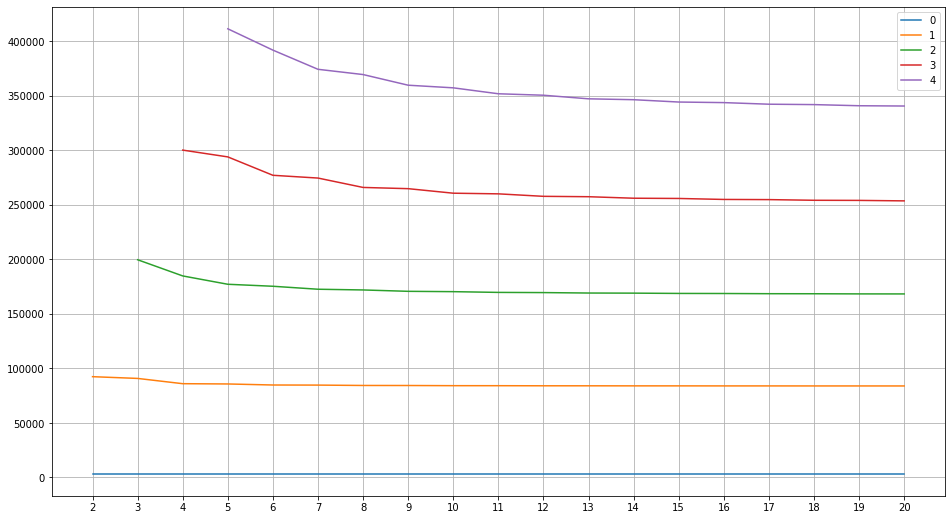

In [ ]:
#Gráfico de resultados
data = []
for i in range (2,n_elementos+1):
    solver = run(d0,d1,L,E,rho,M,i)
    data.append(solver.get_n_min_frequencies(5))
df = pd.DataFrame(data)
df.index = [i for i in range(2,n_elementos+1)]
df.plot(figsize = (16,9), grid = True, xticks = [i for i in range(2,n_elementos+1)])